In [1]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq git+https://github.com/thinkingmachines/geowrangler.git

In [2]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [3]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# hide
# no_test
# conditionally load nb_black cell magic
import sys

if "google.colab" not in sys.modules:
    from IPython import get_ipython

    ipython = get_ipython()
    ipython.magic("reload_ext lab_black")

# Grid Generation Tutorial

> A basic introduction to Geospatial Grids

## Basic Usage
Creating a grid from a geojson file

In [5]:
# hide
import warnings

from IPython.display import display

warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [6]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [7]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [8]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [9]:
# hide_input
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [10]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

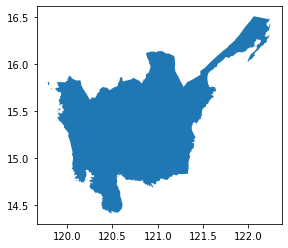

In [11]:
import matplotlib.pyplot as plt

ax = region3_gdf.plot(ax=plt.axes())

In [12]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Creating Grids

Create a grid generator with a size of `50000`. 
The units of the grid size are dependent on the projection of 
the geodataframe, in this case, `EPSG:4326`.

In [13]:
grid_generator5k = grids.SquareGridGenerator(5000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [14]:
%%time
# slow
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 27.5 s, sys: 6.03 ms, total: 27.5 s
Wall time: 27.5 s


Show gridded version of sample geojson file at 5K resolution 

In [15]:
# hide_input
# slow
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1074 row(s)


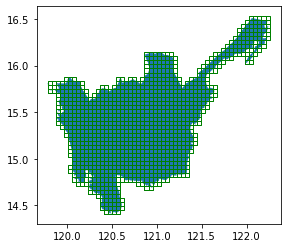

In [16]:
# slow
ax = region3_gdf.plot()
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [17]:
# slow
grid_gdf5k.head()

,x,y,geometry
30,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708..."
31,0,31,"POLYGON ((119.78583 15.75193, 119.83075 15.751..."
32,0,32,"POLYGON ((119.78583 15.79516, 119.83075 15.795..."
79,1,30,"POLYGON ((119.83075 15.70870, 119.87566 15.708..."
81,1,32,"POLYGON ((119.83075 15.79516, 119.87566 15.795..."


<AxesSubplot:>

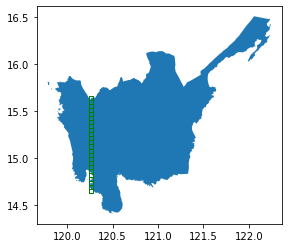

In [18]:
# no_test
ax = region3_gdf.plot()
grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [19]:
grid_generator15k = grids.SquareGridGenerator(15000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [20]:
%%time
# slow
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 3.47 s, sys: 20.2 ms, total: 3.49 s
Wall time: 3.49 s


Show gridded version of sample geojson file at 15K resolution 

In [21]:
# hide_input
# slow
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 154 row(s)


In [22]:
# hide
# slow
assert len(grid_gdf15k) == 154

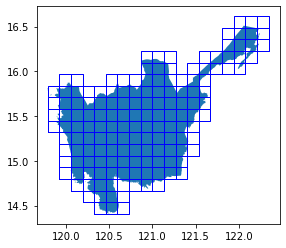

In [23]:
# slow
ax = region3_gdf.plot()
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="blue")

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [24]:
cell1 = grid_gdf5k.head(1)
cell2 = grid_gdf5k.tail(1)

In [25]:
cell1

,x,y,geometry
30,0,30,"POLYGON ((119.78583 15.70870, 119.83075 15.708..."


<AxesSubplot:>

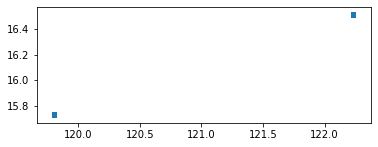

In [26]:
pd.concat([cell1, cell2]).plot()

In [27]:
grids.SquareGridGenerator(
    1000,
    boundary=(119.7858332, 14.4075257, 122.2429921, 16.5092548),
).generate_grid(cell1)

,x,y,geometry
0,0,150,"POLYGON ((119.78583 15.70870, 119.79482 15.708..."
1,0,151,"POLYGON ((119.78583 15.71735, 119.79482 15.717..."
2,0,152,"POLYGON ((119.78583 15.72599, 119.79482 15.725..."
3,0,153,"POLYGON ((119.78583 15.73464, 119.79482 15.734..."
4,0,154,"POLYGON ((119.78583 15.74329, 119.79482 15.743..."
5,0,155,"POLYGON ((119.78583 15.75193, 119.79482 15.751..."
7,1,150,"POLYGON ((119.79482 15.70870, 119.80380 15.708..."
8,1,151,"POLYGON ((119.79482 15.71735, 119.80380 15.717..."
9,1,152,"POLYGON ((119.79482 15.72599, 119.80380 15.725..."
10,1,153,"POLYGON ((119.79482 15.73464, 119.80380 15.734..."


In [28]:
grids.SquareGridGenerator(
    1000,
    boundary=(119.7858332, 14.4075257, 122.2429921, 16.5092548),
).generate_grid(cell2)

,x,y,geometry
0,270,240,"POLYGON ((122.21128 16.48548, 122.22027 16.485..."
1,270,241,"POLYGON ((122.21128 16.49409, 122.22027 16.494..."
2,270,242,"POLYGON ((122.21128 16.50270, 122.22027 16.502..."
3,271,240,"POLYGON ((122.22027 16.48548, 122.22925 16.485..."
4,271,241,"POLYGON ((122.22027 16.49409, 122.22925 16.494..."
5,271,242,"POLYGON ((122.22027 16.50270, 122.22925 16.502..."
6,272,240,"POLYGON ((122.22925 16.48548, 122.23823 16.485..."
7,272,241,"POLYGON ((122.22925 16.49409, 122.23823 16.494..."
8,272,242,"POLYGON ((122.22925 16.50270, 122.23823 16.502..."
9,273,240,"POLYGON ((122.23823 16.48548, 122.24722 16.485..."


## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, it might be better to use custom boundary and iterate througout each aoi 1 at a time.


<AxesSubplot:>

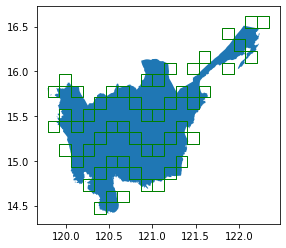

In [29]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot()
sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [30]:
collection = []
grid_generator = grids.SquareGridGenerator(
    1000,
    boundary=(119.7858332, 14.4075257, 122.2429921, 16.5092548),
)
for idx, area in sparse_aois.iterrows():  # Iterate thought each aoi one at a time
    collection.append(
        grid_generator.generate_grid(
            gpd.GeoDataFrame(
                [area], crs=sparse_aois.crs  # Create a geodataframe with 1 row
            )
        )
    )
sparse_grid = pd.concat(collection)

<AxesSubplot:>

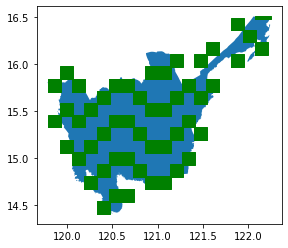

In [31]:
ax = region3_gdf.plot()
sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

<AxesSubplot:>

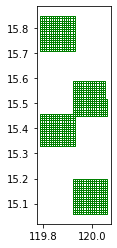

In [32]:
sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

There might be some duplicates using this method if the aois area adjacent or near each other, you can remove the duplicates using the `x` and `y` columns. The combination of `x` and `y` will be unique as long as you pass in the same boundary and cell size.

In [33]:
final_sparse_grid = sparse_grid[~sparse_grid[["x", "y"]].duplicated()].reset_index()
final_sparse_grid

,index,x,y,geometry
0,0,0,106,"POLYGON ((119.78583 15.32785, 119.79482 15.327..."
1,1,0,107,"POLYGON ((119.78583 15.33651, 119.79482 15.336..."
2,2,0,108,"POLYGON ((119.78583 15.34518, 119.79482 15.345..."
3,3,0,109,"POLYGON ((119.78583 15.35384, 119.79482 15.353..."
4,4,0,110,"POLYGON ((119.78583 15.36250, 119.79482 15.362..."
...,...,...,...,...
12539,7,272,241,"POLYGON ((122.22925 16.49409, 122.23823 16.494..."
12540,8,272,242,"POLYGON ((122.22925 16.50270, 122.23823 16.502..."
12541,9,273,240,"POLYGON ((122.23823 16.48548, 122.24722 16.485..."
12542,10,273,241,"POLYGON ((122.23823 16.49409, 122.24722 16.494..."
